# Проект Банки - Анализ оттока клиентов

##  Материалы:
* Презентация https://disk.yandex.ru/i/uhJAxC1ppX1XAQ

Цель исследования - уменьшить отток клиентов банка. 

Основная задача - проанализировать клиентов регионального банка и выделить портрет клиентов, которые склонны уходить из банка.
По результатам исследования дать рекомендации по удержанию клиентов.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from scipy import stats as st

## Вывод данных

In [2]:
df = pd.read_csv('/datasets/bank_dataset.csv')
df.style.background_gradient()
df.head()

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


Имеем следующие данные клиентов банка:
- userid — идентификатор пользователя
- score — баллы кредитного скоринга
- City — город
- Gender — пол
- Age — возраст
- Objects — количество объектов в собственности
- Balance — баланс на счёте
- Products — количество продуктов, которыми пользуется клиент
- CreditCard — есть ли кредитная карта
- Loyalty — активный клиент (1 - активный, 0 - нет)
- estimated_salary — заработная плата клиента
- Churn — ушёл или нет (1 - кто ушли, 0 - кто нет)

In [3]:
df.info() # сразу видны пропуски в balance, и имена колонок хочется поменять

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   userid            10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   City              10000 non-null  object 
 3   Gender            10000 non-null  object 
 4   Age               10000 non-null  int64  
 5   Objects           10000 non-null  int64  
 6   Balance           6383 non-null   float64
 7   Products          10000 non-null  int64  
 8   CreditCard        10000 non-null  int64  
 9   Loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  Churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


## Предобработка данных

### Проверить корректность названия колонок

In [4]:
df.columns = df.columns.str.lower() # сделаем нижний регистр
df = df.rename(columns={'userid': 'user_id', 'creditcard': 'credit_card'}) # переименуем две колонки для стилистики
df['city'] = df['city'].str.lower()
df.head()

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


### Проверка на аномалии, пропуски и дубликаты

In [5]:
df.duplicated().sum() # дубликатов нет

0

В датасете - 10000 строк. Пропуски данных есть только в значениях balance.

Причина пропусков может быть технический сбой или ошибка выгрузка данных по некоторым клиентам, или другое логическое объяснение.  

NAN'ов = 3617 - Это много, может это те кто ушли, и просто средств на счете нет. Как версия.

In [6]:
df[df.isnull().any(axis=1)]['churn'].value_counts() # проверим версию

0    3117
1     500
Name: churn, dtype: int64

In [7]:
df[df.isnull().any(axis=1)]['city'].value_counts() # проверим пропуски в городах

ярославль    2418
рыбинск      1199
Name: city, dtype: int64

In [8]:
df[df.isnull().any(axis=1)]['credit_card'].value_counts() # проверим nan, у тех кто имеет кредитную карту

1    2592
0    1025
Name: credit_card, dtype: int64

Гипотеза c ушедшими клиентами не подтвердилась. Больше пропусков у тех кто не ушел (3117) 

Спишем все на технический сбой, тем более что в Ростове Великом пропусков нет. С кредитками тоже не ясно: пропуски есть у двух категорий клиентов. 
В любом случае такие пропуски заменять нецелесообразно. 

### Проверить соответствие типов данных, если нужно изменить

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   user_id           10000 non-null  int64  
 1   score             10000 non-null  int64  
 2   city              10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   objects           10000 non-null  int64  
 6   balance           6383 non-null   float64
 7   products          10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   loyalty           10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


Имеем два строковых значения - город и пол - присвоим им числовые значения для дальнейшего исследования и кластеризации

In [10]:
df['gender'].unique()  # проверим уникальные значения

array(['Ж', 'М'], dtype=object)

In [11]:
df['city'].value_counts()  # проверим уникальные значения городов

ярославль         5014
ростов великий    2509
рыбинск           2477
Name: city, dtype: int64

Заменим категориальные значения на числовые:
0 - женский пол, 1 - мужской пол 

In [12]:
df = df.replace({'gender': {"Ж": 0, "М": 1}})
df['gender'].value_counts() #проверим, все ли поменялось

1    5457
0    4543
Name: gender, dtype: int64

Колонку Город представим вместо одного категориального поля в множество бинарных полей

In [13]:
df = pd.get_dummies(df)
df.head()   

,user_id,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_ростов великий,city_рыбинск,city_ярославль
0,15677338,619,0,42,2,NaN,1,1,1,101348.88,1,0,0,1
1,15690047,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,15662040,502,0,42,8,159660.80,3,1,0,113931.57,1,0,0,1
3,15744090,699,0,39,1,NaN,2,0,0,93826.63,0,0,0,1
4,15780624,850,0,43,2,125510.82,1,1,1,79084.10,0,0,1,0


## Исследовательский анализ данных

### Оценить статические данные методом describe

In [14]:
df.describe().round(2) # посмотрим на датасет с помощью describe

,user_id,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,city_ростов великий,city_рыбинск,city_ярославль
count,10000.00,10000.00,10000.00,10000.00,10000.00,6383.00,10000.00,10000.00,10000.00,10000.00,10000.0,10000.00,10000.00,10000.0
mean,15733676.57,650.53,0.55,38.92,5.01,119827.49,1.53,0.71,0.52,100090.24,0.2,0.25,0.25,0.5
std,71936.19,96.65,0.50,10.49,2.89,30095.06,0.58,0.46,0.50,57510.49,0.4,0.43,0.43,0.5
min,15608437.00,350.00,0.00,18.00,0.00,3768.69,1.00,0.00,0.00,11.58,0.0,0.00,0.00,0.0
25%,15671264.25,584.00,0.00,32.00,3.00,100181.98,1.00,0.00,0.00,51002.11,0.0,0.00,0.00,0.0
50%,15733474.00,652.00,1.00,37.00,5.00,119839.69,1.00,1.00,1.00,100193.92,0.0,0.00,0.00,1.0
75%,15795969.75,718.00,1.00,44.00,7.00,139512.29,2.00,1.00,1.00,149388.25,0.0,1.00,0.00,1.0
max,15858426.00,850.00,1.00,92.00,10.00,250898.09,4.00,1.00,1.00,199992.48,1.0,1.00,1.00,1.0


Выводы по дискрайбу:
1. Средний кредитный скор - 650. Медиана - 652. Максимум 850.
2. Пол - мужчин чуть больше, 54.5 % 
3. Средний возраст почти 39 лет. Медиана - 37. 50 % клиентов в возрасте от 32 до 44 лет. Максимум - 92.
4. Количество объектов среднее 5. Максимум - 10.
5. Баланс на счете среднее почти 120 тысяч, назовем ед.денег. У 50 % клиентов от 100 до 139,5 тысяч на счету.
6. Количество банковских продуктов средне 1,5, медиана 1.
7. Кредитная карта есть у 70% клиентов.
8. Активный клиент - почти половина 51,5 %.
9. Заработная плата среднее - 100000, медиана тоже 100000.
10. 20 % клиентов являются ушедшими.
11. 50 % живет в Ярославле, и прибл. по 25% в Рыбинске и Ростове Великом.

Явных выбросов нет. Смущает только возраст максимум - 92.

In [15]:
df.query('age >= 72')['churn'].value_counts() # количество ушедших из старше 72 лет.

0    102
1      4
Name: churn, dtype: int64

In [16]:
np.percentile(df['age'], [95, 99]) #рассмотрим возраст на перцентили 95 и 99.

array([60., 72.])

Не более 1 % клиентов (99 перцентиль) имеют возраст от 72 до 92 лет и 5 % клиентов старше 60 лет. И интересно, что из клиентов старше 72 лет, ушли только 4 чел. из 106 (4 %). Старшему поколению несвойственно искать и менять на другой банк. Количество от общего числа датасета не большое, но тем не менее.

### Оценить средние значение признаков в группах — тех, кто ушел и тех, кто остался

In [17]:
df.groupby('churn').mean().round(2)

,user_id,score,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,city_ростов великий,city_рыбинск,city_ярославль
churn,,,,,,,,,,,,,
0,15733903.88,651.85,0.57,37.41,5.03,119535.86,1.54,0.71,0.55,99738.39,0.21,0.26,0.53
1,15732787.96,645.35,0.44,44.84,4.93,120746.97,1.48,0.70,0.36,101465.68,0.40,0.20,0.40


Средние значения по признаку ушел-не ушел дают такие значения.

- В группе ушедших - мужчин меньше 44 %. А в группе оставшихся мужчин больше - 57%. 
- Средний возраст ушедших выше (почти 45 лет), чем не ушедших (37 лет).
- Степень активности в группе тех кто остается - 55 %, чем "ушли" - 36 %.
- По локации: группа ушедших распределяется - Ярославь и Ростов Великий = по 40 %, и в Рыбинске 20%.

По остальным факторам средние значения отличаются несильно в двух группах.

### Визуализация распределения признаков по Ушел - Не ушел (столбчатые гистограммы)

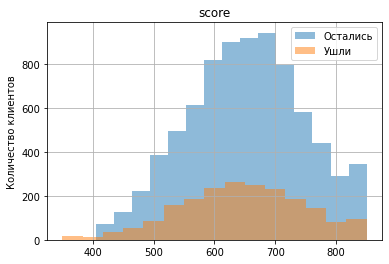

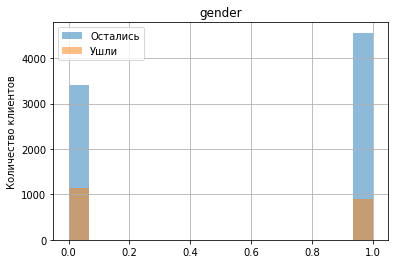

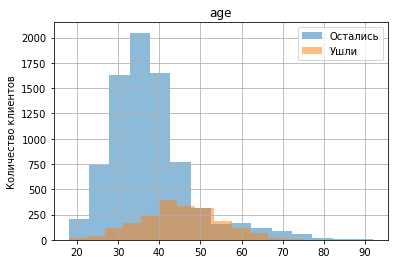

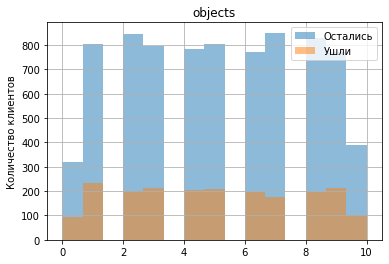

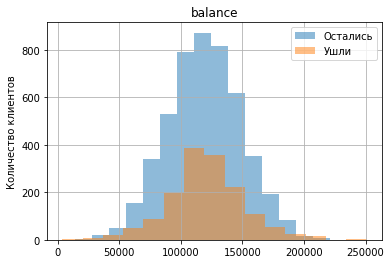

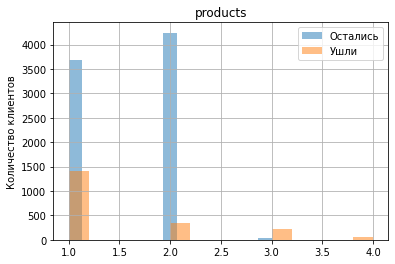

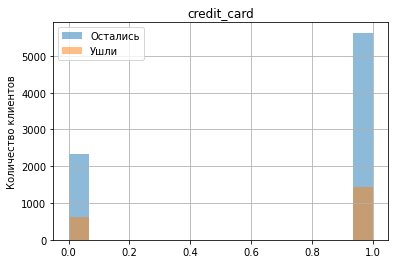

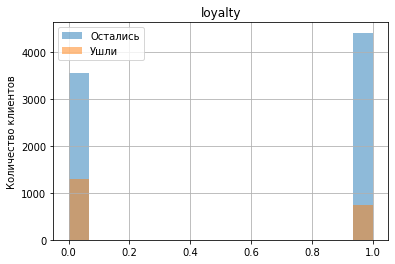

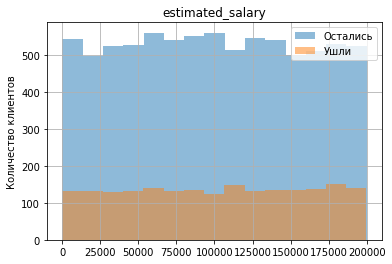

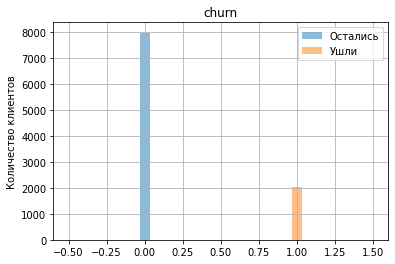

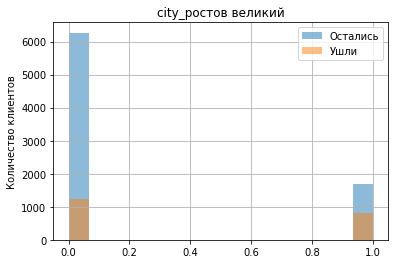

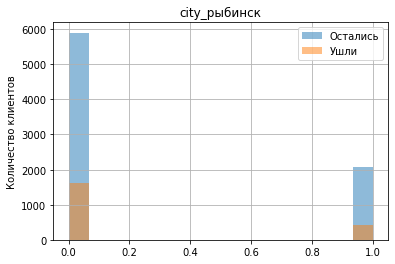

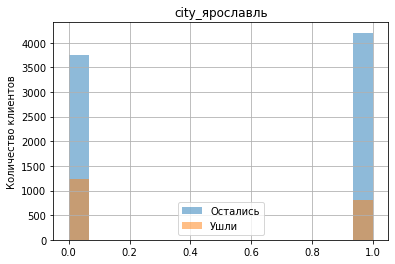

In [18]:
for col in df.drop('user_id', axis=1).columns: # функция для вывода графиков, исключили user_id
    df.groupby('churn')[col].hist(bins=15, alpha=0.5)
    plt.title(col)
    plt.legend(['Остались', 'Ушли'])
    plt.ylabel('Количество клиентов')
    plt.show()       

Про графики распределения:

беглый взгляд дает понимание, что на отток клиентов влияют такие признаки: 
- пол (женщинам свойственно уходить больше, чем мужчинам)
- возраст - пик ушедших на графике смещен вправо от пика не ушедших, уходить клиентам свойственно в диапазоне 40-52 лет, а на рубеже приблизительно 55 лет ушедших даже больше чем оставшихся клиентов.
- количество ушедших, имеющих один банковский продукт сильно больше, по среднему значению это не было так очевидно. А самые стабильные - клиенты имеющие два продукта. Два продукта - самое оптимальное значение для банка.
- активность положительно влияет на не уход 
- В Ростове Великом одна треть клиентов являются ушедшими.

### Определить степень зависимости признаков от оттока (матрица корреляций, тепловая карта)

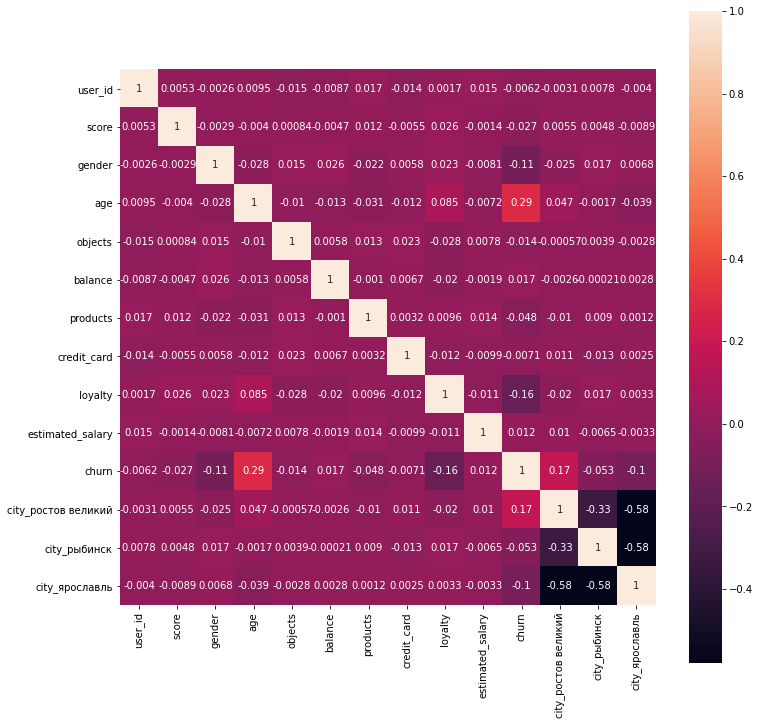

In [19]:
cm = df.corr() #вычисляем матрицу корреляций
fig, ax = plt.subplots(figsize=(12, 12)) # тепловая карту для матрицы корреляций
sns.heatmap(cm, annot=True, square=True) 
plt.show() 

Степень зависимости оттока от других признаков может отличатся:
1. Скор, количество объектов, баланс на счете, количество продуктов, наличие кредитной карты, размер зп не влияют. Зависимость почти нулевая.
2. Активность клиента (0,16), пол (0,11) и локация клиента имеет слабое влияние на отток клиентов, до 0,17. Причем по локации это особенно заметно по Ростову Великому (0,17), и в Ярославле (0.1)
3. Возраст имеет высокую зависимость, 0,29. Т.е. возраст является самым определяющим фактором при уходе клиентов.

Примечательно, что количество продуктов на матрице корреляций не показало зависимости от оттока, видимо уравновешивается к нулю.

In [20]:
df.groupby('products').mean().round(2) # посмотрим средние значения разложив по количеству продуктов  

,user_id,score,gender,age,objects,balance,credit_card,loyalty,estimated_salary,churn,city_ростов великий,city_рыбинск,city_ярославль
products,,,,,,,,,,,,,
1,15732367.90,649.12,0.55,39.67,4.97,119894.16,0.70,0.50,99487.26,0.28,0.27,0.24,0.49
2,15734841.49,652.19,0.55,37.75,5.05,119660.94,0.71,0.53,100452.01,0.08,0.23,0.26,0.52
3,15741816.49,648.11,0.44,43.20,5.00,119475.69,0.71,0.42,104318.13,0.83,0.36,0.25,0.39
4,15719361.27,653.58,0.37,45.68,5.30,122260.61,0.68,0.48,104763.72,1.00,0.40,0.12,0.48


Действительно % оттока ниже в группе имеющих два продукта (8%). Активность выше всех (0,53) и средний возраст самый молодой - 37,7 лет. Три или четыре банковских продукта - не удачный вариант.

Попробуем это учесть при кластеризации. 

## Кластеризация клиентов

In [21]:
X = df.drop(['churn', 'balance'], axis=1) # признаки кроме колонок ушел-не ушел, и баланс, т.к. там есть nan

In [22]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
x_sc = scaler.fit_transform(X) # обучаем нормализатор

In [23]:
linked = linkage(x_sc, method = 'ward') # строим матрицу расстояний

### Дендрограмма

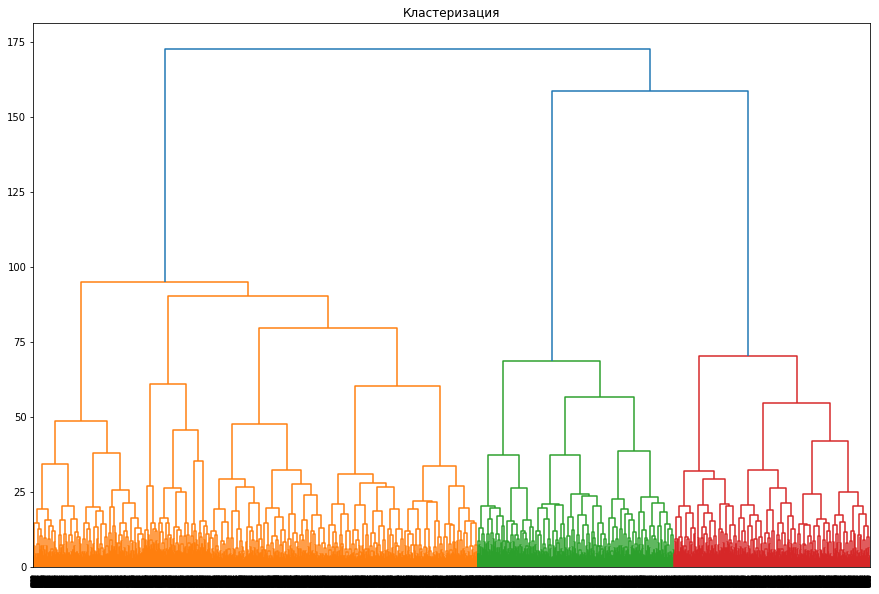

In [24]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация')
plt.show()

Можно выделить как минимум 3 кластера клиентов, но лучше 5, 6 или 7.

### Кластеризации по алгоритму K-Means

In [25]:
km = KMeans(n_clusters=7, random_state=0) 
# число кластеров приняла n=7, при этом значение удалось выделить кластер клиентов с одним продуктом
labels = km.fit_predict(x_sc) 
df['cluster'] = labels
df.groupby('cluster').mean().round(2).T

cluster,0,1,2,3,4,5,6
user_id,15732458.01,15735538.25,15730230.16,15734654.41,15731962.42,15734837.46,15733754.49
score,652.11,650.56,649.35,651.33,651.40,651.51,647.23
gender,1.00,0.00,1.00,0.56,0.51,0.54,0.54
age,39.30,38.83,36.95,38.89,40.57,38.84,38.64
objects,5.09,4.95,5.14,5.03,5.01,5.02,4.92
balance,118623.67,118496.42,123854.98,119814.99,119868.33,119569.39,119747.53
products,1.55,1.54,1.48,1.54,1.00,2.12,1.54
credit_card,1.00,1.00,1.00,0.69,0.71,0.72,0.00
loyalty,1.00,0.51,0.00,0.53,0.47,0.53,0.52
estimated_salary,99594.70,98589.95,100745.75,99440.57,101029.03,101211.59,100967.80


In [26]:
df.groupby(['cluster'])['gender'].count() #посмотрим на количество клиентов в каждом кластере

cluster
0    1016
1    1578
2     949
3    2477
4    1349
5    1160
6    1471
Name: gender, dtype: int64

### Описание поведения клиентов в кластерах  и выделение кластера склонного к оттоку

Сразу отмечу кластер более склонный к оттоку - кластер 4 - 0,43 

Кластер 0

- количество клиентов 1016 - 10 % всего датасета
- отток самый низкий - 0,08
- состоит только из мужчин
- живут в Ярославле
- Средний возраст - 39,3 лет
- Среднее количество продуктов - 1,55
- все владельцы кредитный карт - 1
- Абсолютная активность - 1

Кластер 1

- количество клиентов 1578 - 15 % всего датасета
- отток самый высокий в Ярославле - 0,20
- Это только женщины Ярославля
- Средний возраст - 38,9 лет
- Среднее количество продуктов - 1,54
- все владельцы кредитный карт - 1
- Активные клиенты на 51 %

Кластер 2

- количество клиентов 949 - почти 10 % всего датасета
- отток - 0,17
- Это вторая половина мужчин Ярославля, но моложе кластера 0
- Средний возраст - 37 лет
- Среднее количество продуктов - 1,48
- все владельцы кредитный карт - 1
- Не активные клиенты - 0

Кластер 3

- количество клиентов 2477 - 24 % всего датасета, самая многочисленная группа получилась
- отток - 0,17
- Это все жители Рыбинска 
- Средний возраст - 39 лет
- Среднее количество продуктов - 1,54
- Активные клиенты на 53 %

Кластер 4 и 5

- количество клиентов 1349 и 1160 - 25 % датасета (оба кластера)
- отток - 0,43 (кластер 4 - с самым большим оттоком клиентов) и 0,2 (кластер 5)
- Это все жители Ростова Великого (оба кластера) 
- Средний возраст - 40,5 и 39 лет
- Среднее количество продуктов - 1,0 (кластер 4) и более 2 продуктов (кластер 5)
- Основное отличие кластеров в количестве банковских продуктов, и разница в оттоках между ними в 2 раза.
- Активные клиенты на 47% и 53 %

Кластер 6

- количество клиентов 1471 
- отток - 0,16
- Еще одна группа из Ярославля
- Смежанная по полу - 54 % мужчин 
- Средний возраст - 38,6 лет
- Среднее количество продуктов - 1,54
- все владельцы кредитный карт - 1
- Активные клиенты на 51 %

## Проверка статистических гипотез

### Проверка гипотезы различия дохода между теми клиентами, которые ушли и теми, которые остались

Проверим различается ли средний доход ушедших клиентов или нет с помощью ttest

scipy.stats.ttest_ind - специальный метод, который используется для проверки гипотезы о равенстве среднего двух генеральных совокупностей

Нулевая гипотеза - средний доход клиентов из двух групп равен.

Альтернативая гипотеза - средний доход клиентов их двух групп не равен.

In [27]:
array_1 = df.query('churn==1')['estimated_salary']
array_2 = df.query('churn==0')['estimated_salary']

alpha = .05    #критический уровень статистической значимости, возьмем общепринятое пороговые значения — 5%
 
results = st.ttest_ind(array_1, array_2)
 
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть гипотезу, гипотеза о различии дохода не подтвердилась, доходы равны")

p-значение: 0.22644042802223352
Не получилось отвергнуть гипотезу, гипотеза о различии дохода не подтвердилась, доходы равны


Вероятность получить равенство средних не маленькая, поэтому нулевую гипотезу не отвергаем.

### Проверка гипотезы различия баланса на счету между ушедшими клиентами, и теми, которые остались

Проверим различается ли средний баланс на счете ушедших клиентов и не ушедших с помощью ttest

Нулевая гипотеза - средний баланс клиентов из двух групп равен.

Альтернативая гипотеза - средний баланс клиентов их двух групп не равен.

In [28]:
array_1 = df.dropna(subset=['balance']).query('churn==1')['balance']
array_2 = df.dropna(subset=['balance']).query('churn==0')['balance']

alpha = .05    #критический уровень статистической значимости, возьмем общепринятое пороговые значения — 5%
 
results = st.ttest_ind(array_1, array_2)
 
print('p-значение:', results.pvalue)
 
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть гипотезу, гипотеза о различии баланса не подтвердилась, балансы равны")

p-значение: 0.16924734893322796
Не получилось отвергнуть гипотезу, гипотеза о различии баланса не подтвердилась, балансы равны


## Выводы и рекомендации

Основные выводы:

1. Идеальный портрет клиента в идеальном мире: мужчина, 39 лет, проживающий в Ярославле, активен, имеет кредитную карту, пользователь банковских продуктов в количестве 2 шт. (1,55)

2. Не идеальный клиент в реальном мире: Житель Ростова Великого, мужчина или женщина, 40,5 лет, малоактивен, имеет один банковский продукт, и вероятнее всего это кредитная карта (0,7).

3. Признаки сильно определяющие степень оттока клиентов банка: возраст, локация (город), пол, количество банковских продуктов.

4. Признаки, характеризующие финансовое состояние клиента, не влияют на отток клиентов. Это такие как - баланс на счете, размер заработной платы, количество объектов, кредитный скор.  


Рекомендации региональному банку по удержанию клиентов:
- Обратить внимание на работу банка в городе Ростове Великом. Предполагаю, что могут быть причины не связанные с клиентами и их половозрастным составом. Может страдать качество обслуживание в отделении банка, или отделения банка и (или) банкоматы неудобно расположены для жителей города. 
- Стремится увеличивать количество банковских продуктов на каждого клиента. Отток клиентов можно сократить минимум в 2 раза. Оптимальное число банковских продуктов равно 2. 
- Обратить внимание на предложение и качество банковских продуктов, возможно улучшив их можно несложно удержать старых клиентов и привлечь новых.   
- Проработать возрастную группу клиентов старше 40, чтобы понять причины, почему именно клиенты этого возраста покидают банк.
- Сделать акцент на привлечение клиентов молодого возрасто до 30 лет. Через 3-5 лет это будут самые стабильные клиенты.
- Обратить внимание на активность женщин, т.к. есть отличия в цифрах оттока мужчин и женщин. Для исследования можно взять кластер 1 - это женщины  Ярославля, с коэф. оттока 0,20.